# EDA
В данном ноутбуке представлен EDA датасета и построение модели на табличных признаках.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.metrics import print_metrics

In [2]:
train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [3]:
print(train.shape)
print(test.shape)

(312908, 16)
(70274, 12)


In [4]:
train.head()

,item_id,order_date,item_condition,item_price,category_name,subcategory_name,microcat_name,seller_id,buyer_id,title,description,image_name,real_weight,real_height,real_length,real_width
0,185689,2024-09-27,Б/у,3000.0,Транспорт,Запчасти и аксессуары,Салон,1942218,1935418,Ручка АКПП mercedes w203 avangarde,Ручка рычаг акпп на Мерседес В203 mercedes w20...,185689.jpg,0.370,10.0,23.0,19.0
1,1914373,2024-11-07,Новое с биркой,5990.0,Личные вещи,"Одежда, обувь, аксессуары",Зимние куртки и пуховики,2164034,1753243,Пуховик Moncler голубой (52 размер),Объявление для заказа 📲\n\nАвито доставка 🚚\n\...,1914373.jpg,2.486,14.0,37.0,24.0
2,361626,2024-12-15,Новое,1200.0,Транспорт,Запчасти и аксессуары,Двигатель,621511,1233378,Запчасти на ford фокус1,"Опора задняя,двигатель w тигуан 1,4 150 б.у",361626.jpg,0.640,7.0,23.0,18.0
3,534927,2024-01-20,Б/у,13000.0,Электроника,"Игры, приставки и программы",Игровые приставки и аксессуары,998450,1082324,Ps3 cechc 08 скальпирована HEN(полностью испра...,"В комплекте приставка, провода(зарядка, питани...",534927.jpg,7.100,20.0,35.0,20.0
4,199043,2024-07-28,Отличное,300.0,Личные вещи,"Одежда, обувь, аксессуары","Джемперы, свитеры, кардиганы",528098,477834,Свитер трикотаж 44 р-р Reserved,Свитер Pull&Bear (пул энд бир)\n44 размер\nНад...,199043.jpg,0.400,7.0,23.0,11.0


Посмотрим на число значений у категориальных признаков.

In [5]:
print(len(train["item_condition"].unique()))
print(len(train["category_name"].unique()))
print(len(train["subcategory_name"].unique()))

9
5
25


In [6]:
print(len(train["seller_id"].unique()))
print(len(train["buyer_id"].unique()))

264430
279410


In [7]:
print(
    len(
        set(train["seller_id"].value_counts().index.to_list())
        & set(test["seller_id"].value_counts().index.to_list())
    )
)

print(
    len(
        set(train["buyer_id"].value_counts().index.to_list())
        & set(test["buyer_id"].value_counts().index.to_list())
    )
)

13877
11835


In [8]:
print(train["seller_id"].value_counts().mean())
print(train["buyer_id"].value_counts().mean())

1.183330181900692
1.11988833613686


Пересчение между id покупателей и продавцов трейна и теста низкое, при этом среднее число объявлений на одного человека - лишь немногим больше 1, поэтому, кажется, что эти категориальные признаки будут мало полезными и лишь сильно увеличат размерность признакового пространства, поэтому далее было решено использовать только "item_price", "item_condition", "category_name", "subcategory_name", "microcat_name".

In [9]:
train[
    [
        "item_price",
        "item_condition",
        "category_name",
        "subcategory_name",
        "microcat_name",
    ]
].isna().sum(axis=0)

item_price              0
item_condition      16294
category_name           0
subcategory_name        0
microcat_name           0
dtype: int64

In [10]:
# заполним пропуски в item_condition, явно указав, что значение отсутствует
train["item_condition"] = train["item_condition"].fillna("Нет")

Посмотрим, как связаны м/у собой предсказываемые характеристики

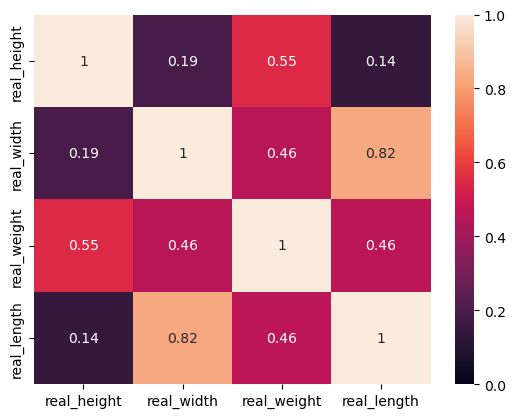

In [11]:
sns.heatmap(
    train[["real_height", "real_width", "real_weight", "real_length"]].corr(
        method="spearman"
    ),
    annot=True,
    vmin=0,
)
plt.show()

Предсказываемые характеристики, между собой скоррелированы, что логично. Сильнее всего коррелирует длина и ширина, при этом высота коррелирует с остальными слабее всего

Так как мы оптимизируем метрику MAE от логарифмов, будем сразу логарифмы предсказывать, а на тесте делать обратное преобразование

In [12]:
train["log_real_weight"] = np.log(train["real_weight"] + 1)
train["log_real_height"] = np.log(train["real_height"] + 1)
train["log_real_length"] = np.log(train["real_length"] + 1)
train["log_real_width"] = np.log(train["real_width"] + 1)

In [31]:
train_X = train[
    [
        "item_price",
        "item_condition",
        "category_name",
        "subcategory_name",
        "microcat_name",
    ]
]

train_y = train[
    ["log_real_weight", "log_real_height", "log_real_length", "log_real_width"]
]

In [32]:
test_X = test[
    [
        "item_price",
        "item_condition",
        "category_name",
        "subcategory_name",
        "microcat_name",
    ]
]
test_X["item_condition"] = test_X["item_condition"].fillna("Нет")

/tmp/ipykernel_18799/1823470126.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X["item_condition"] = test_X["item_condition"].fillna("Нет")


## Обучение бейзлайна

Обучим модель линейной регрессии на табличных признаках. Для препроцессинга категорий используем OneHotEncoder

In [33]:
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, random_state=42, test_size=0.1
)

In [16]:
categorical_cols = [
    "item_condition",
    "category_name",
    "subcategory_name",
    "microcat_name",
]
numerical_cols = ["item_price"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=False),
            categorical_cols,
        ),
    ]
)

In [ ]:
oh = preprocessor.fit(train_X)
train_X_encoded = oh.transform(train_X)
val_X_encoded = oh.transform(val_X)

In [ ]:
lrs = {}
for col in tqdm(train_y.columns):
    lr = Ridge()
    lr = lr.fit(train_X_encoded, train_y[col])
    lrs[col] = lr

100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


In [ ]:
preds = []
for col in tqdm(train_y.columns):
    pred = lrs[col].predict(val_X_encoded)
    preds.append(pred)
preds = np.stack(preds, axis=1)

100%|██████████| 4/4 [00:00<00:00, 42.68it/s]


In [20]:
print_metrics(val_y, preds)

log_real_weight:
	mae=0.3294
	r2=0.3354
	corr=0.5793
log_real_height:
	mae=0.5491
	r2=0.1832
	corr=0.4280
log_real_length:
	mae=0.3135
	r2=0.1616
	corr=0.4020
log_real_width:
	mae=0.3187
	r2=0.1639
	corr=0.4049
Mean MAE: 0.3777


## RegressorChain
Предварительный результат получен, однако мы никак не учитываем связь между предсказываемыми призгнаками, обучая отдельные модели. `RegressorChain` позволяет учить модели последовательно, постепенно добавляя предсказанные значение одного из таргетов в качестве признака для предсказания следующих таргетов. Процедура повторяется со случайными порядками таргетов для охвата разных их комбинаций.

In [ ]:
base_lr = Ridge()
chains = [
    RegressorChain(base_lr, order="random", random_state=i) for i in range(10)
]
for chain in tqdm(chains):
    chain.fit(train_X_encoded, train_y)

100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


In [ ]:
Y_pred_chains = np.array([chain.predict(val_X_encoded) for chain in chains])
Y_pred_ensemble = Y_pred_chains.mean(axis=0)

In [26]:
print_metrics(val_y, Y_pred_ensemble)

log_real_weight:
	mae=0.3294
	r2=0.3354
	corr=0.5793
log_real_height:
	mae=0.5491
	r2=0.1832
	corr=0.4280
log_real_length:
	mae=0.3135
	r2=0.1616
	corr=0.4020
log_real_width:
	mae=0.3187
	r2=0.1639
	corr=0.4049
Mean MAE: 0.3777


Результат не поменялся. Возможно, линейные модели слишком простые, чтобы уловить взаимосвязи между предсказываемыми таргетами.

## CatBoost
Обучим градиентный бустинг, воспользуемся тем, что модель CatBoostRegressor умеет сама предобрабатывать категории. Будем сразу обучать в режиме множественной регрессии.

In [27]:
from catboost import CatBoostRegressor, Pool

In [34]:
train_pool = Pool(train_X, train_y, cat_features=categorical_cols)
val_pool = Pool(val_X, val_y, cat_features=categorical_cols)

In [ ]:
cat = CatBoostRegressor(
    loss_function="MultiRMSE",
    od_wait=50,
    n_estimators=1000,
    use_best_model=True,
)
cat.fit(
    train_pool, eval_set=val_pool, metric_period=10, plot=False, verbose=True
)

In [36]:
cat_preds = cat.predict(val_X)
print_metrics(val_y, cat_preds)

log_real_weight:
	mae=0.3057
	r2=0.4149
	corr=0.6442
log_real_height:
	mae=0.5367
	r2=0.2110
	corr=0.4594
log_real_length:
	mae=0.3061
	r2=0.1862
	corr=0.4319
log_real_width:
	mae=0.3102
	r2=0.1942
	corr=0.4410
Mean MAE: 0.3646


Удалось несколько повысить качество, но не сильно. Нужно добавлять новые признаки.